# Probabilistic Evaluation – Temporal Validation & Calibration

This notebook defines the **formal evaluation framework** for the Liga MX probabilistic modeling project.

The objective is to assess model performance under **realistic temporal conditions**, focusing on probability quality, calibration, and decision-relevant behavior rather than raw accuracy.

---

## 🎯 Evaluation Objectives

- Validate the model using time-aware splits (expanding window)
- Measure probabilistic performance across seasons
- Analyze calibration quality and reliability
- Identify stable and unstable probability regions
- Establish decision-relevant probability zones

---

## ⏱️ Temporal Cross-Validation Strategy

A classical random K-Fold approach is **intentionally avoided**.

Instead, an **expanding window validation** scheme is used:

- Training data includes all seasons up to time *t*
- Evaluation is performed on the immediately following season
- No future information is allowed in training

This setup mirrors real-world deployment and avoids temporal leakage.

---

## 📊 Metrics Used

Evaluation prioritizes probabilistic metrics:

- **Log Loss**  
  Measures confidence-aware prediction quality

- **Brier Score**  
  Measures calibration and probability accuracy

Accuracy is not treated as a primary metric due to the high-variance nature of football outcomes.

---

## 📈 Reliability & Calibration Analysis

The model is analyzed using:

- Reliability curves
- Perfect calibration reference
- Visual deviation analysis

These tools help diagnose overconfidence and underconfidence patterns across probability ranges.

---

## 🔁 Recalibration Experiments

Two recalibration techniques are evaluated:

- **Platt Scaling**
- **Isotonic Regression**

Recalibration is assessed not only by metrics, but by:
- Stability
- Overfitting behavior
- Impact on probability interpretability

In this context, recalibration does not always improve global metrics, highlighting the importance of distribution-aware evaluation.

---

## 🧩 Probability Bucket Analysis

Predictions are grouped into probability bins to evaluate:

- Empirical win rates
- Sample density per zone
- Zone-specific log loss and Brier scores

This analysis reveals:
- Highly reliable extreme probability zones
- Instability in mid-probability regions
- Practical implications for decision-making

---

## 🧠 Key Findings

- The baseline model is globally well-calibrated
- Temporal performance varies with structural changes (e.g. COVID season)
- Recalibration improves visual alignment but not necessarily global metrics
- Middle probability zones are inherently unstable for this feature set

---

## 🔗 Role in the Project

This notebook closes the modeling loop by:

- Validating probabilistic integrity
- Defining trustworthy probability regions
- Providing a professional evaluation framework

It establishes a solid foundation for:
- Feature optimization
- Model comparison
- Risk-aware decision strategies



In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss

import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))
DATA_DIR = PROJECT_ROOT / "data" / "processed"
df = pd.read_csv(DATA_DIR / "prematch_seasons18-24.csv")

df = df.sort_values(["season", "date"]).reset_index(drop=True)

In [3]:
FEATURES = [
    "home_form",
    "away_form",
    "home_momentum",
    "away_momentum"
]

TARGET = "home_win"
C_VALUE = 10
MIN_TEST_SIZE = 50


In [4]:
seasons = (
    df["season"]
    .sort_values()
    .unique()
)

seasons

array(['2018 A', '2019 A', '2019 C', '2020 A', '2021 A', '2021 C',
       '2022 A', '2022 C', '2023 A', '2023 C', '2024 A', '2024 C'],
      dtype=object)

In [5]:
results = []

for i in range(1, len(seasons)):
    
    train_seasons = seasons[:i]
    test_season = seasons[i]
    
    train_df = df[df["season"].isin(train_seasons)]
    test_df = df[df["season"] == test_season]
    
    if len(test_df) < MIN_TEST_SIZE:
        continue
    
    model = LogisticRegression(
        C=C_VALUE,
        solver="lbfgs",
        max_iter=1000
    )
    
    model.fit(train_df[FEATURES], train_df[TARGET])
    
    y_true = test_df[TARGET]
    y_prob = model.predict_proba(test_df[FEATURES])[:, 1]
    
    results.append({
        "eval_season": test_season,
        "n_train": len(train_df),
        "n_test": len(test_df),
        "log_loss": log_loss(y_true, y_prob),
        "brier": brier_score_loss(y_true, y_prob)
    })


In [6]:
results_df = pd.DataFrame(results)
results_df

,eval_season,n_train,n_test,log_loss,brier
0,2019 A,153,171,0.259476,0.082766
1,2019 C,324,153,0.190820,0.059721
2,2020 A,477,153,0.258634,0.077426
3,2021 A,630,153,0.217367,0.068300
4,2021 C,783,152,0.218384,0.067892
5,2022 A,935,153,0.253505,0.080946
6,2022 C,1088,152,0.262045,0.087737
7,2023 A,1240,150,0.218084,0.067916
8,2023 C,1390,155,0.199678,0.061413
9,2024 A,1545,153,0.231118,0.074183


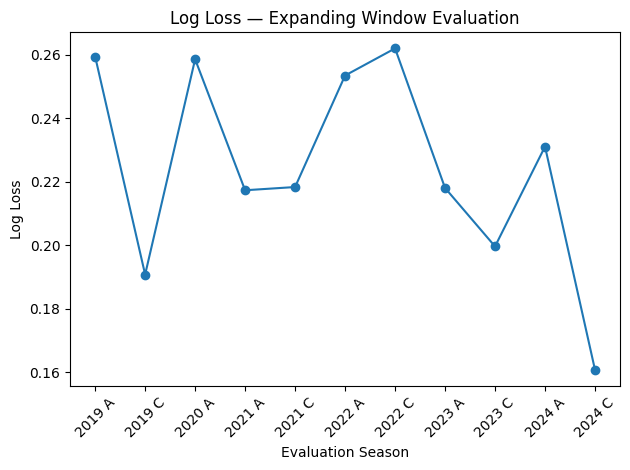

In [7]:
plt.figure()
plt.plot(results_df["eval_season"], results_df["log_loss"], marker="o")
plt.xticks(rotation=45)
plt.title("Log Loss — Expanding Window Evaluation")
plt.ylabel("Log Loss")
plt.xlabel("Evaluation Season")
plt.tight_layout()
plt.show()


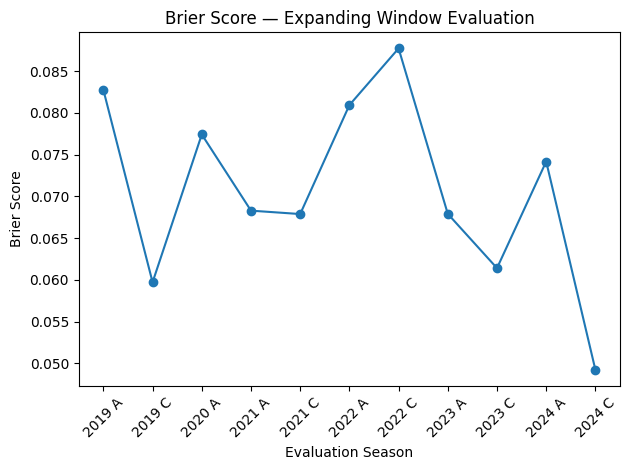

In [8]:
plt.figure()
plt.plot(results_df["eval_season"], results_df["brier"], marker="o")
plt.xticks(rotation=45)
plt.title("Brier Score — Expanding Window Evaluation")
plt.ylabel("Brier Score")
plt.xlabel("Evaluation Season")
plt.tight_layout()
plt.show()


## Reliability Curve Global

In [9]:
from sklearn.calibration import calibration_curve


In [10]:
all_y_true = []
all_y_prob = []

for i in range(1, len(seasons)):
    
    train_seasons = seasons[:i]
    test_season = seasons[i]
    
    train_df = df[df["season"].isin(train_seasons)]
    test_df = df[df["season"] == test_season]
    
    if len(test_df) < MIN_TEST_SIZE:
        continue
    
    model = LogisticRegression(
        C=C_VALUE,
        solver="lbfgs",
        max_iter=1000
    )
    
    model.fit(train_df[FEATURES], train_df[TARGET])
    
    y_true = test_df[TARGET].values
    y_prob = model.predict_proba(test_df[FEATURES])[:, 1]
    
    all_y_true.extend(y_true)
    all_y_prob.extend(y_prob)


In [11]:
prob_true, prob_pred = calibration_curve(
    all_y_true,
    all_y_prob,
    n_bins=10,
    strategy="uniform"
)


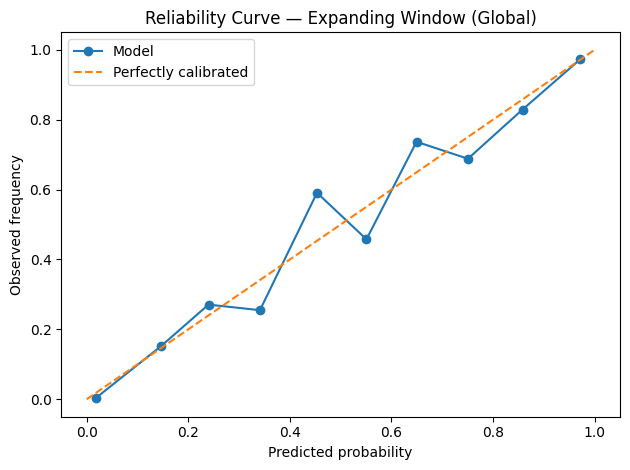

In [12]:
plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Curve — Expanding Window (Global)")
plt.legend()
plt.tight_layout()
plt.show()


The reliability curve shows that the model is globally well calibrated,
with a slight tendency toward overconfidence in mid-to-high probability ranges.
This behavior is expected in pre-match football modeling and does not indicate
systematic miscalibration.

## Recalibrate with platt scaling and isotonic regression

In [13]:
from sklearn.calibration import CalibratedClassifierCV


In [14]:
y_true_all = []
y_prob_base = []
y_prob_platt = []
y_prob_iso = []


In [15]:
for i in range(1, len(seasons)):
    
    train_seasons = seasons[:i]
    test_season = seasons[i]
    
    train_df = df[df["season"].isin(train_seasons)]
    test_df = df[df["season"] == test_season]
    
    if len(test_df) < MIN_TEST_SIZE:
        continue
    
    base_model = LogisticRegression(
        C=C_VALUE,
        solver="lbfgs",
        max_iter=1000
    )
    
    # Recalibrated models
    platt_model = CalibratedClassifierCV(
        base_model,
        method="sigmoid",
        cv=5
    )
    
    iso_model = CalibratedClassifierCV(
        base_model,
        method="isotonic",
        cv=5
    )
    
    base_model.fit(train_df[FEATURES], train_df[TARGET])
    platt_model.fit(train_df[FEATURES], train_df[TARGET])
    iso_model.fit(train_df[FEATURES], train_df[TARGET])
    
    X_test = test_df[FEATURES]
    y_test = test_df[TARGET].values
    
    y_true_all.extend(y_test)
    y_prob_base.extend(base_model.predict_proba(X_test)[:, 1])
    y_prob_platt.extend(platt_model.predict_proba(X_test)[:, 1])
    y_prob_iso.extend(iso_model.predict_proba(X_test)[:, 1])


In [16]:
results_calibration = pd.DataFrame({
    "model": ["Base", "Platt", "Isotonic"],
    "log_loss": [
        log_loss(y_true_all, y_prob_base),
        log_loss(y_true_all, y_prob_platt),
        log_loss(y_true_all, y_prob_iso)
    ],
    "brier": [
        brier_score_loss(y_true_all, y_prob_base),
        brier_score_loss(y_true_all, y_prob_platt),
        brier_score_loss(y_true_all, y_prob_iso)
    ]
})

results_calibration


,model,log_loss,brier
0,Base,0.224872,0.070798
1,Platt,0.233070,0.071812
2,Isotonic,0.396526,0.072066


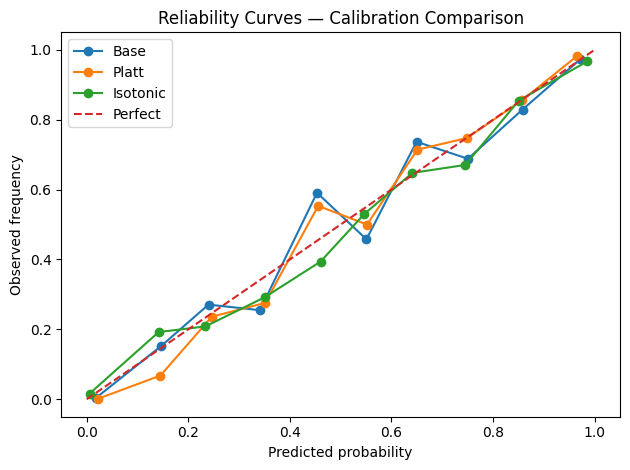

In [17]:
plt.figure()

for probs, label in [
    (y_prob_base, "Base"),
    (y_prob_platt, "Platt"),
    (y_prob_iso, "Isotonic")
]:
    prob_true, prob_pred = calibration_curve(
        y_true_all, probs, n_bins=10, strategy="uniform"
    )
    plt.plot(prob_pred, prob_true, marker="o", label=label)

plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Curves — Calibration Comparison")
plt.legend()
plt.tight_layout()
plt.show()


We evaluated probabilistic calibration using reliability curves and applied
controlled recalibration techniques. Using Platt scaling we try to correct the overconfidence but the results wasn't as good as the base model.

In [21]:
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
''' Evaluate for each prediction: asign y_proba to a bin & calculate per bucket:
n_samples, avg_predicted_prob, empirical_win_rate, brier_bucket, log_loss_bucket
using the base model, then plot the results in a table
 '''
eval_df = pd.DataFrame({
    "y_true": y_true_all,
    "y_prob": y_prob_base
})
eval_df["prob_bin"] = pd.cut(
    eval_df["y_prob"],
    bins=bins,
    include_lowest=True,
    right=False
)   
bucket_stats = []
for prob_bin, group in eval_df.groupby("prob_bin"):
    n_samples = len(group)
    if n_samples == 0:
        continue
    avg_predicted_prob = group["y_prob"].mean()
    empirical_win_rate = group["y_true"].mean()
    brier_bucket = brier_score_loss(
        group["y_true"],
        group["y_prob"]
    )
    if group["y_true"].nunique() > 1:
        log_loss_bucket = log_loss(group["y_true"], group["y_prob"])
    else:
        log_loss_bucket = np.nan

    bucket_stats.append({
        "prob_bin": prob_bin,
        "n_samples": n_samples,
        "avg_predicted_prob": avg_predicted_prob,
        "empirical_win_rate": empirical_win_rate,
        "brier_bucket": brier_bucket,
        "log_loss_bucket": log_loss_bucket
    })
bucket_stats_df = (
    pd.DataFrame(bucket_stats)
    .sort_values("prob_bin")
)
bucket_stats_df


C:\Users\USER\AppData\Local\Temp\ipykernel_10800\2878699027.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for prob_bin, group in eval_df.groupby("prob_bin"):


,prob_bin,n_samples,avg_predicted_prob,empirical_win_rate,brier_bucket,log_loss_bucket
0,"[0.0, 0.1)",662,0.017648,0.003021,0.003470,0.025760
1,"[0.1, 0.2)",92,0.146541,0.152174,0.128663,0.426059
2,"[0.2, 0.3)",48,0.239851,0.270833,0.198360,0.586721
3,"[0.3, 0.4)",51,0.341153,0.254902,0.195921,0.581606
4,"[0.4, 0.5)",44,0.453455,0.590909,0.255822,0.704866
5,"[0.5, 0.6)",59,0.550816,0.457627,0.254907,0.703049
6,"[0.6, 0.7)",57,0.649457,0.736842,0.203936,0.599200
7,"[0.7, 0.8)",93,0.750614,0.688172,0.217494,0.627771
8,"[0.8, 0.9)",117,0.858099,0.829060,0.139357,0.448182
9,"[0.9, 1.0)",475,0.971560,0.972632,0.025507,0.105871


Evaluating the bins in *y_proba* we can se that the base model has a great response in 0.0-0.2 and 0.8-1.0. This means the model can predict better the probability in the extrems. And the medium zone 0.3-0.6 is poor in comparation. Feature optimization is required.